In [1]:
from dask.distributed import Client

client = Client("tcp://10.32.5.211:41649")
client

Client Scheduler: tcp://10.32.5.211:41649 Dashboard: /user/0000-0002-8176-9465/proxy/8787/status,Cluster Workers: 30 Cores: 60 Memory: 345.00 GB


# WMT - $S$ budget using xhistogram

In [2]:
import xarray as xr
from matplotlib import pyplot as plt
import gcsfs
import dask
import dask.array as dsa
import numpy as np
import intake
import gsw
%matplotlib inline

In [3]:
#loading flux ds
ds_slt = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/SOSE/budget_slt.zarr'))

#loading surface term ds
ds_slt_surf_terms = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/SOSE/budget_surf_slt.zarr'))

#loading theta and salt ds
t_s = xr.open_zarr(gcsfs.GCSMap('pangeo-tmp/stb2145/SOSE/t_s.zarr'))

In [4]:
#merging datasets to be organized
ds = xr.merge([ds_slt, ds_slt_surf_terms, t_s])
ds

<xarray.Dataset>
Dimensions:                   (XC: 2160, YC: 320, Z: 42, time: 438)
Coordinates:
  * XC                        (XC) float32 0.083333336 0.25 ... 359.75 359.9167
  * YC                        (YC) float32 -77.87497 -77.7083 ... -24.7083
  * Z                         (Z) float32 -5.0 -15.5 -27.0 ... -5325.0 -5575.0
  * time                      (time) datetime64[ns] 2005-01-06 ... 2010-12-31
Data variables:
    conv_horiz_adv_flux_SLT   (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 319, 2159), meta=np.ndarray>
    conv_horiz_diff_flux_SLT  (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 319, 2159), meta=np.ndarray>
    conv_vert_adv_flux_SLT    (time, Z, YC, XC) float32 dask.array<chunksize=(1, 41, 320, 2160), meta=np.ndarray>
    conv_vert_diff_flux_SLT   (time, Z, YC, XC) float32 dask.array<chunksize=(1, 41, 320, 2160), meta=np.ndarray>
    total_tendency_SLT_truth  (time, Z, YC, XC) float64 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>
    

In [5]:
#rechunking by `chunksize=ds.shape` of each variable so xhistogram can be happy
ds = ds.chunk({'XC': -1, 'YC': -1, 'Z': -1})
ds

<xarray.Dataset>
Dimensions:                   (XC: 2160, YC: 320, Z: 42, time: 438)
Coordinates:
  * XC                        (XC) float32 0.083333336 0.25 ... 359.75 359.9167
  * YC                        (YC) float32 -77.87497 -77.7083 ... -24.7083
  * Z                         (Z) float32 -5.0 -15.5 -27.0 ... -5325.0 -5575.0
  * time                      (time) datetime64[ns] 2005-01-06 ... 2010-12-31
Data variables:
    conv_horiz_adv_flux_SLT   (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>
    conv_horiz_diff_flux_SLT  (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>
    conv_vert_adv_flux_SLT    (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>
    conv_vert_diff_flux_SLT   (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>
    total_tendency_SLT_truth  (time, Z, YC, XC) float64 dask.array<chunksize=(1, 42, 320, 2160), meta=np.ndarray>
    

In [ ]:
ds.SALT.values.min()

In [ ]:
ds.SALT.values.max()

## Tracer Budgets

Here we will do the heat and salt budgets for SOSE. In integral form, these budgets can be written as

$$
\mathcal{V} \frac{\partial S}{\partial t} = G^S_{adv} + G^S_{diff} + G^S_{surf} + G^S_{linfs}
$$


$$
\mathcal{V} \frac{\partial \theta}{\partial t} = G^\theta_{adv} + G^\theta_{diff} + G^\theta_{surf} + G^\theta_{linfs} + G^\theta_{sw}
$$

where $\mathcal{V}$ is the volume of the grid cell. The terms on the right-hand side are called _tendencies_. They add up to the total tendency (the left hand side).

The first term is the convergence of advective fluxes. The second is the convergence of diffusive fluxes. The third is the explicit surface flux. The fourth is the correction due to the linear free-surface approximation. The fifth is shortwave penetration (only for temperature).

### Flux Divergence

First we define a function to calculate the convergence of the advective and diffusive fluxes, since this has to be repeated for both tracers.

In [6]:
from xhistogram.xarray import histogram
#histogram?

In [11]:
salt_bins = np.arange(32, 38.1, 0.1)
salt_bins

array([32. , 32.1, 32.2, 32.3, 32.4, 32.5, 32.6, 32.7, 32.8, 32.9, 33. ,
       33.1, 33.2, 33.3, 33.4, 33.5, 33.6, 33.7, 33.8, 33.9, 34. , 34.1,
       34.2, 34.3, 34.4, 34.5, 34.6, 34.7, 34.8, 34.9, 35. , 35.1, 35.2,
       35.3, 35.4, 35.5, 35.6, 35.7, 35.8, 35.9, 36. , 36.1, 36.2, 36.3,
       36.4, 36.5, 36.6, 36.7, 36.8, 36.9, 37. , 37.1, 37.2, 37.3, 37.4,
       37.5, 37.6, 37.7, 37.8, 37.9, 38. , 38.1])

In [13]:
def hist_var(direction, tendency, suffix):
    """Compute histogram of `tendency` flux of tracer `suffix`
    where `tendency` is `ADV` or `DIFF`, `suffix` is `TH` or `SLT`,
    and `direction` is `horiz` or `vert`. Return a new xarray.Dataset."""
    
    var = 'conv_' + direction + '_' + tendency + '_flux_' + suffix
    hist_var = histogram(ds.SALT, bins=[salt_bins], weights=ds[var], dim=['XC', 'YC', 'Z'])
    return hist_var

In [14]:
adv_vert_hist = hist_var('vert', 'adv', 'SLT').load()
adv_horiz_hist = hist_var('horiz', 'adv', 'SLT').load()
diff_vert_hist = hist_var('vert', 'diff', 'SLT').load()
diff_horiz_hist = hist_var('horiz', 'diff', 'SLT').load()

distributed.client - WARNING - Couldn't gather 1 keys, rescheduling {"('getitem-fd1a28a44bc7cd1a24c97a1e67ae44fa', 166, 0)": ()}


In [17]:
surf_flux_hist = histogram(ds.SALT, bins=[salt_bins], weights=ds.surface_flux_conv_SLT, dim=['XC', 'YC', 'Z']).load()
lin_fs_hist = histogram(ds.SALT, bins=[salt_bins], weights=ds.lin_fs_correction_SLT, dim=['XC', 'YC', 'Z']).load()
tot_tend_truth_hist = histogram(ds.SALT, bins=[salt_bins], weights=ds.total_tendency_SLT_truth, dim=['XC', 'YC', 'Z']).load()

In [18]:
ds_hist = xr.merge([adv_horiz_hist.rename('adv_horiz_hist'), 
                    adv_vert_hist.rename('adv_vert_hist'),
                    diff_horiz_hist.rename('diff_horiz_hist'),
                    diff_vert_hist.rename('diff_vert_hist'),
                    surf_flux_hist.rename('surf_flux_hist'),
                    lin_fs_hist.rename('lin_fs_hist'),
                    tot_tend_truth_hist.rename('tot_tend_truth_hist')])
ds_hist

<xarray.Dataset>
Dimensions:              (SALT_bin: 61, time: 438)
Coordinates:
  * time                 (time) datetime64[ns] 2005-01-06 ... 2010-12-31
  * SALT_bin             (SALT_bin) float64 32.05 32.15 32.25 ... 37.95 38.05
Data variables:
    adv_horiz_hist       (time, SALT_bin) float64 3.722e+06 ... 5.178e+05
    adv_vert_hist        (time, SALT_bin) float64 -1.17e+07 ... -5.168e+05
    diff_horiz_hist      (time, SALT_bin) float64 1.6e+04 ... 1.553e+03
    diff_vert_hist       (time, SALT_bin) float64 3.04e+05 ... -6.334e+03
    surf_flux_hist       (time, SALT_bin) float64 -2.345e+06 ... 6.483e+03
    lin_fs_hist          (time, SALT_bin) float64 8.302e+06 1.229e+07 ... 51.08
    tot_tend_truth_hist  (time, SALT_bin) float64 -1.881e+06 ... 2.506e+03

In [19]:
tot_tend_hist = (ds_hist.adv_horiz_hist + ds_hist.adv_vert_hist + 
                 ds_hist.diff_horiz_hist + ds_hist.diff_vert_hist +
                 ds_hist.surf_flux_hist + ds_hist.lin_fs_hist).load()

In [20]:
ds_hist['tot_tend_hist'] = tot_tend_hist

## Entire WG column budget

In [21]:
lower_lat = 0
upper_lat = 78
left_lon = 1788
right_lon = 2159

In [22]:
#set the boundaries
lat_range = dict(YC=slice(lower_lat, upper_lat))
lon_range = dict(XC=slice(left_lon, right_lon))

In [23]:
ds_wg = ds.isel(**lat_range, **lon_range)
ds_wg

<xarray.Dataset>
Dimensions:                   (XC: 371, YC: 78, Z: 42, time: 438)
Coordinates:
  * XC                        (XC) float32 298.08334 298.25 ... 359.58334 359.75
  * YC                        (YC) float32 -77.87497 -77.7083 ... -65.04163
  * Z                         (Z) float32 -5.0 -15.5 -27.0 ... -5325.0 -5575.0
  * time                      (time) datetime64[ns] 2005-01-06 ... 2010-12-31
Data variables:
    conv_horiz_adv_flux_SLT   (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 78, 371), meta=np.ndarray>
    conv_horiz_diff_flux_SLT  (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 78, 371), meta=np.ndarray>
    conv_vert_adv_flux_SLT    (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 78, 371), meta=np.ndarray>
    conv_vert_diff_flux_SLT   (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 78, 371), meta=np.ndarray>
    total_tendency_SLT_truth  (time, Z, YC, XC) float64 dask.array<chunksize=(1, 42, 78, 371), meta=np.ndarray>
    lin_fs_cor

In [24]:
def hist_var(direction, tendency, suffix):
    """Compute histogram of `tendency` flux of tracer `suffix`
    where `tendency` is `ADV` or `DIFF`, `suffix` is `TH` or `SLT`,
    and `direction` is `horiz` or `vert`. Return a new xarray.Dataset."""
    
    var = 'conv_' + direction + '_' + tendency + '_flux_' + suffix
    hist_var = histogram(ds_wg.SALT, bins=[salt_bins], weights=ds_wg[var], dim=['XC', 'YC', 'Z'])
    return hist_var

In [26]:
ds_wg

<xarray.Dataset>
Dimensions:                   (XC: 371, YC: 78, Z: 42, time: 438)
Coordinates:
  * XC                        (XC) float32 298.08334 298.25 ... 359.58334 359.75
  * YC                        (YC) float32 -77.87497 -77.7083 ... -65.04163
  * Z                         (Z) float32 -5.0 -15.5 -27.0 ... -5325.0 -5575.0
  * time                      (time) datetime64[ns] 2005-01-06 ... 2010-12-31
Data variables:
    conv_horiz_adv_flux_SLT   (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 78, 371), meta=np.ndarray>
    conv_horiz_diff_flux_SLT  (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 78, 371), meta=np.ndarray>
    conv_vert_adv_flux_SLT    (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 78, 371), meta=np.ndarray>
    conv_vert_diff_flux_SLT   (time, Z, YC, XC) float32 dask.array<chunksize=(1, 42, 78, 371), meta=np.ndarray>
    total_tendency_SLT_truth  (time, Z, YC, XC) float64 dask.array<chunksize=(1, 42, 78, 371), meta=np.ndarray>
    lin_fs_cor

In [27]:
adv_vert_hist_wg = hist_var('vert', 'adv', 'SLT').load()
adv_horiz_hist_wg = hist_var('horiz', 'adv', 'SLT').load()
diff_vert_hist_wg = hist_var('vert', 'diff', 'SLT').load()
diff_horiz_hist_wg = hist_var('horiz', 'diff', 'SLT').load()

In [29]:
surf_flux_hist_wg = histogram(ds_wg.SALT, bins=[salt_bins], weights=ds_wg.surface_flux_conv_SLT, dim=['XC', 'YC', 'Z']).load()
lin_fs_hist_wg = histogram(ds_wg.SALT, bins=[salt_bins], weights=ds_wg.lin_fs_correction_SLT, dim=['XC', 'YC', 'Z']).load()
tot_tend_truth_hist_wg = histogram(ds_wg.SALT, bins=[salt_bins], weights=ds_wg.total_tendency_SLT_truth, dim=['XC', 'YC', 'Z']).load()

In [32]:
ds_hist_wg = xr.merge([adv_horiz_hist_wg.rename('adv_horiz_hist_wg'), 
                       adv_vert_hist_wg.rename('adv_vert_hist_wg'),
                       diff_horiz_hist_wg.rename('diff_horiz_hist_wg'),
                       diff_vert_hist_wg.rename('diff_vert_hist_wg'),
                       surf_flux_hist_wg.rename('surf_flux_hist_wg'),
                       lin_fs_hist_wg.rename('lin_fs_hist_wg'),
                       tot_tend_truth_hist_wg.rename('tot_tend_truth_hist_wg')])
ds_hist_wg

<xarray.Dataset>
Dimensions:                 (SALT_bin: 61, time: 438)
Coordinates:
  * time                    (time) datetime64[ns] 2005-01-06 ... 2010-12-31
  * SALT_bin                (SALT_bin) float64 32.05 32.15 32.25 ... 37.95 38.05
Data variables:
    adv_horiz_hist_wg       (time, SALT_bin) float64 8.352e+05 2.698e+06 ... 0.0
    adv_vert_hist_wg        (time, SALT_bin) float64 -3.544e+06 ... 0.0
    diff_horiz_hist_wg      (time, SALT_bin) float64 4.628e+03 8.297e+03 ... 0.0
    diff_vert_hist_wg       (time, SALT_bin) float64 1.25e+05 2.055e+05 ... 0.0
    surf_flux_hist_wg       (time, SALT_bin) float64 -9.984e+05 ... 0.0
    lin_fs_hist_wg          (time, SALT_bin) float64 2.726e+06 5.267e+06 ... 0.0
    tot_tend_truth_hist_wg  (time, SALT_bin) float64 -8.512e+05 ... 0.0

In [36]:
tot_tend_hist_wg = (ds_hist_wg.adv_horiz_hist_wg + ds_hist_wg.adv_vert_hist_wg + 
                 ds_hist_wg.diff_horiz_hist_wg + ds_hist_wg.diff_vert_hist_wg +
                 ds_hist_wg.surf_flux_hist_wg + ds_hist_wg.lin_fs_hist_wg).load()
ds_hist_wg['tot_tend_hist_wg'] = tot_tend_hist_wg

In [37]:
ds_hist_wg

<xarray.Dataset>
Dimensions:                 (SALT_bin: 61, time: 438)
Coordinates:
  * time                    (time) datetime64[ns] 2005-01-06 ... 2010-12-31
  * SALT_bin                (SALT_bin) float64 32.05 32.15 32.25 ... 37.95 38.05
Data variables:
    adv_horiz_hist_wg       (time, SALT_bin) float64 8.352e+05 2.698e+06 ... 0.0
    adv_vert_hist_wg        (time, SALT_bin) float64 -3.544e+06 ... 0.0
    diff_horiz_hist_wg      (time, SALT_bin) float64 4.628e+03 8.297e+03 ... 0.0
    diff_vert_hist_wg       (time, SALT_bin) float64 1.25e+05 2.055e+05 ... 0.0
    surf_flux_hist_wg       (time, SALT_bin) float64 -9.984e+05 ... 0.0
    lin_fs_hist_wg          (time, SALT_bin) float64 2.726e+06 5.267e+06 ... 0.0
    tot_tend_truth_hist_wg  (time, SALT_bin) float64 -8.512e+05 ... 0.0
    tot_tend_hist_wg        (time, SALT_bin) float64 -8.512e+05 ... 0.0

#### Time-Avged

In [38]:
ds_hist_wg_mean = ds_hist_wg.mean(dim='time')
ds_hist_wg_mean

<xarray.Dataset>
Dimensions:                 (SALT_bin: 61)
Coordinates:
  * SALT_bin                (SALT_bin) float64 32.05 32.15 32.25 ... 37.95 38.05
Data variables:
    adv_horiz_hist_wg       (SALT_bin) float64 1.602e+04 2.348e+04 ... 0.0 0.0
    adv_vert_hist_wg        (SALT_bin) float64 -2.068e+04 -3.447e+04 ... 0.0 0.0
    diff_horiz_hist_wg      (SALT_bin) float64 426.4 464.9 390.9 ... 0.0 0.0 0.0
    diff_vert_hist_wg       (SALT_bin) float64 2.178e+03 2.764e+03 ... 0.0 0.0
    surf_flux_hist_wg       (SALT_bin) float64 -5.532e+03 -7.407e+03 ... 0.0 0.0
    lin_fs_hist_wg          (SALT_bin) float64 5.787e+03 1.224e+04 ... 0.0 0.0
    tot_tend_truth_hist_wg  (SALT_bin) float64 -1.781e+03 -2.963e+03 ... 0.0 0.0
    tot_tend_hist_wg        (SALT_bin) float64 -1.81e+03 -2.929e+03 ... 0.0 0.0

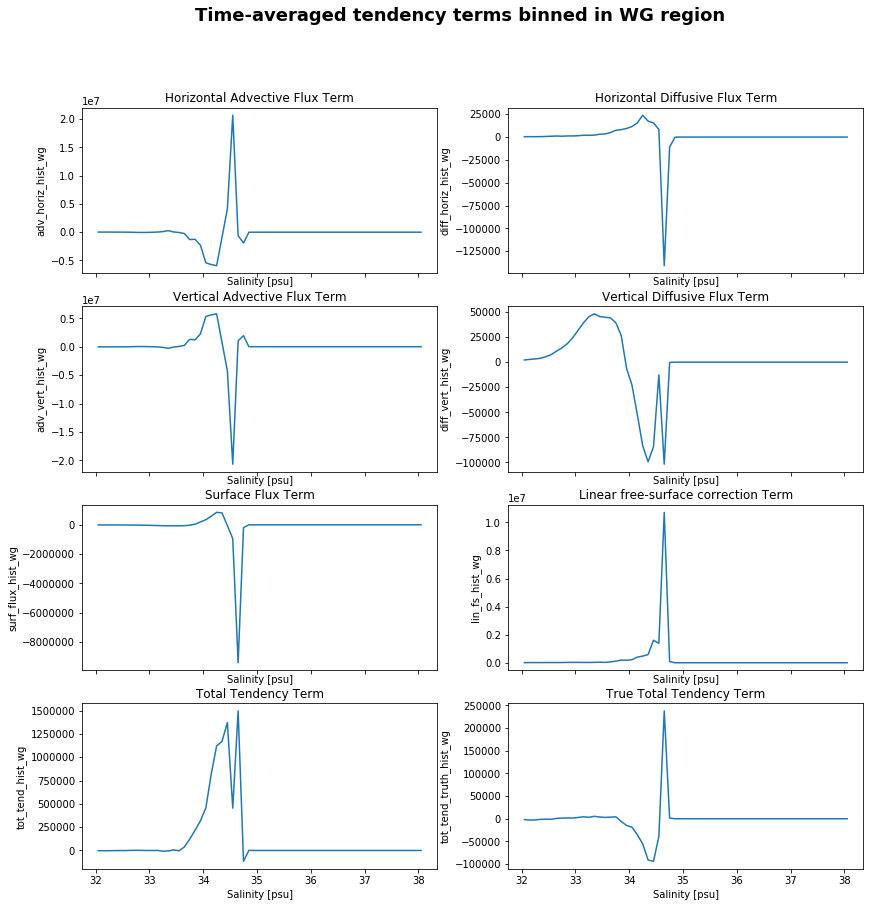

<Figure size 432x288 with 0 Axes>

In [40]:
fig, axes = plt.subplots(nrows=4, ncols=2, sharex=True, figsize=(14,14))

ds_hist_wg_mean.adv_horiz_hist_wg.transpose().plot(ax=axes[0,0])#, cmap='seismic')
ds_hist_wg_mean.diff_horiz_hist_wg.transpose().plot(ax=axes[0,1])#, cmap='seismic')
ds_hist_wg_mean.adv_vert_hist_wg.transpose().plot(ax=axes[1,0])#, cmap='seismic')
ds_hist_wg_mean.diff_vert_hist_wg.transpose().plot(ax=axes[1,1])#, cmap='seismic')
ds_hist_wg_mean.surf_flux_hist_wg.transpose().plot(ax=axes[2,0])#, cmap='seismic')
ds_hist_wg_mean.lin_fs_hist_wg.transpose().plot(ax=axes[2,1])#, cmap='seismic')
ds_hist_wg_mean.tot_tend_hist_wg.transpose().plot(ax=axes[3,0])#, cmap='seismic')
ds_hist_wg_mean.tot_tend_truth_hist_wg.transpose().plot(ax=axes[3,1])

#axes[0,0].set_ylim(-2, 5)
#axes[0,1].set_ylim(-2, 5)
#axes[1,0].set_ylim(-2, 5)
#axes[1,1].set_ylim(-2, 5)
#axes[2,0].set_ylim(-2, 5)
#axes[2,1].set_ylim(-2, 5)
#axes[3,0].set_ylim(-2, 5)
#axes[3,1].set_ylim(-2, 5)

fig.suptitle('Time-averaged tendency terms binned in WG region', fontsize=18, fontweight='bold')

axes[0,0].title.set_text('Horizontal Advective Flux Term')
axes[0,1].title.set_text('Horizontal Diffusive Flux Term')
axes[1,0].title.set_text('Vertical Advective Flux Term')
axes[1,1].title.set_text('Vertical Diffusive Flux Term')
axes[2,0].title.set_text('Surface Flux Term')
axes[2,1].title.set_text('Linear free-surface correction Term')
axes[3,0].title.set_text('Total Tendency Term')
axes[3,1].title.set_text('True Total Tendency Term')

plt.show() #this seems to work to make suptitle displayed neatly above
plt.tight_layout();

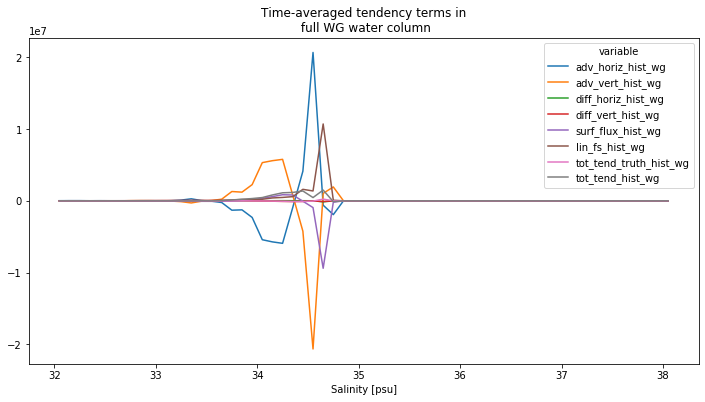

In [42]:
plt.figure(figsize=(12,6))
ds_hist_wg_mean.to_array().plot.line(x='SALT_bin')
plt.title('Time-averaged tendency terms in\n full WG water column');

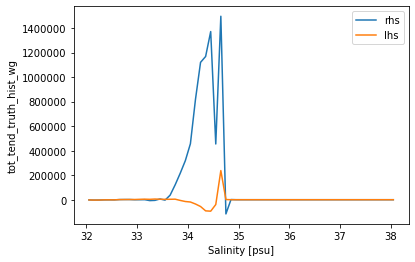

In [43]:
ds_hist_wg_mean.tot_tend_hist_wg.plot(label='rhs')
ds_hist_wg_mean.tot_tend_truth_hist_wg.plot(label='lhs')
plt.legend();

## Interior WG column

In [44]:
#index locations corresponding to above lat/lon coordinates
lower_lat_lower = 0
upper_lat_lower = 71
left_lon_lower = 1794
right_lon_lower = 2159

lower_cell_range = dict(Zl=[27, 42])
lower_cell_range_z = dict(Z=slice(27, 42))

In [45]:
#set the boundaries
lat_range_lower = dict(YC=slice(lower_lat_lower, upper_lat_lower))
lon_range_lower = dict(XC=slice(left_lon_lower, right_lon_lower))

In [48]:
ds_wg_lower = ds.isel(**lat_range_lower, **lon_range_lower, **lower_cell_range_z)
ds_wg_lower

<xarray.Dataset>
Dimensions:                   (XC: 365, YC: 71, Z: 15, time: 438)
Coordinates:
  * XC                        (XC) float32 299.08334 299.25 ... 359.58334 359.75
  * YC                        (YC) float32 -77.87497 -77.7083 ... -66.2083
  * Z                         (Z) float32 -2046.0 -2319.0 ... -5325.0 -5575.0
  * time                      (time) datetime64[ns] 2005-01-06 ... 2010-12-31
Data variables:
    conv_horiz_adv_flux_SLT   (time, Z, YC, XC) float32 dask.array<chunksize=(1, 15, 71, 365), meta=np.ndarray>
    conv_horiz_diff_flux_SLT  (time, Z, YC, XC) float32 dask.array<chunksize=(1, 15, 71, 365), meta=np.ndarray>
    conv_vert_adv_flux_SLT    (time, Z, YC, XC) float32 dask.array<chunksize=(1, 15, 71, 365), meta=np.ndarray>
    conv_vert_diff_flux_SLT   (time, Z, YC, XC) float32 dask.array<chunksize=(1, 15, 71, 365), meta=np.ndarray>
    total_tendency_SLT_truth  (time, Z, YC, XC) float64 dask.array<chunksize=(1, 15, 71, 365), meta=np.ndarray>
    lin_fs_corre

In [49]:
adv_vert_hist_wg_lower = hist_var('vert', 'adv', 'SLT').load()
adv_horiz_hist_wg_lower = hist_var('horiz', 'adv', 'SLT').load()
diff_vert_hist_wg_lower = hist_var('vert', 'diff', 'SLT').load()
diff_horiz_hist_wg_lower = hist_var('horiz', 'diff', 'SLT').load()

In [50]:
total_tendency_truth_hist_wg_lower = histogram(ds_wg_lower.SALT, bins=[salt_bins], 
                                      weights=ds_wg_lower.total_tendency_SLT_truth, 
                                      dim=['XC', 'YC', 'Z']).load()

In [51]:
ds_hist_wg_lower = xr.merge([adv_horiz_hist_wg_lower.rename('adv_horiz_hist_wg_lower'), 
                             adv_vert_hist_wg_lower.rename('adv_vert_hist_wg_lower'),
                             diff_horiz_hist_wg_lower.rename('diff_horiz_hist_wg_lower'),
                             diff_vert_hist_wg_lower.rename('diff_vert_hist_wg_lower'),
                             total_tendency_truth_hist_wg_lower.rename('tot_tend_truth_hist_wg_lower')])
ds_hist_wg_lower

<xarray.Dataset>
Dimensions:                       (SALT_bin: 61, time: 438)
Coordinates:
  * time                          (time) datetime64[ns] 2005-01-06 ... 2010-12-31
  * SALT_bin                      (SALT_bin) float64 32.05 32.15 ... 37.95 38.05
Data variables:
    adv_horiz_hist_wg_lower       (time, SALT_bin) float64 8.352e+05 ... 0.0
    adv_vert_hist_wg_lower        (time, SALT_bin) float64 -3.544e+06 ... 0.0
    diff_horiz_hist_wg_lower      (time, SALT_bin) float64 4.628e+03 ... 0.0
    diff_vert_hist_wg_lower       (time, SALT_bin) float64 1.25e+05 ... 0.0
    tot_tend_truth_hist_wg_lower  (time, SALT_bin) float64 0.0 0.0 ... 0.0 0.0

In [52]:
tot_tend_hist_wg_lower = (ds_hist_wg_lower.adv_horiz_hist_wg_lower + 
                          ds_hist_wg_lower.adv_vert_hist_wg_lower + 
                          ds_hist_wg_lower.diff_horiz_hist_wg_lower + 
                          ds_hist_wg_lower.diff_vert_hist_wg_lower).load()

In [53]:
ds_hist_wg_lower['tot_tend_hist_wg_lower'] = tot_tend_hist_wg_lower
ds_hist_wg_lower

<xarray.Dataset>
Dimensions:                       (SALT_bin: 61, time: 438)
Coordinates:
  * time                          (time) datetime64[ns] 2005-01-06 ... 2010-12-31
  * SALT_bin                      (SALT_bin) float64 32.05 32.15 ... 37.95 38.05
Data variables:
    adv_horiz_hist_wg_lower       (time, SALT_bin) float64 8.352e+05 ... 0.0
    adv_vert_hist_wg_lower        (time, SALT_bin) float64 -3.544e+06 ... 0.0
    diff_horiz_hist_wg_lower      (time, SALT_bin) float64 4.628e+03 ... 0.0
    diff_vert_hist_wg_lower       (time, SALT_bin) float64 1.25e+05 ... 0.0
    tot_tend_truth_hist_wg_lower  (time, SALT_bin) float64 0.0 0.0 ... 0.0 0.0
    tot_tend_hist_wg_lower        (time, SALT_bin) float64 -2.579e+06 ... 0.0

#### Time-Avged

In [54]:
ds_hist_wg_lower_mean = ds_hist_wg_lower.mean(dim='time')
ds_hist_wg_lower_mean

<xarray.Dataset>
Dimensions:                       (SALT_bin: 61)
Coordinates:
  * SALT_bin                      (SALT_bin) float64 32.05 32.15 ... 37.95 38.05
Data variables:
    adv_horiz_hist_wg_lower       (SALT_bin) float64 1.602e+04 2.348e+04 ... 0.0
    adv_vert_hist_wg_lower        (SALT_bin) float64 -2.068e+04 ... 0.0
    diff_horiz_hist_wg_lower      (SALT_bin) float64 426.4 464.9 ... 0.0 0.0
    diff_vert_hist_wg_lower       (SALT_bin) float64 2.178e+03 2.764e+03 ... 0.0
    tot_tend_truth_hist_wg_lower  (SALT_bin) float64 0.0 0.0 0.0 ... 0.0 0.0 0.0
    tot_tend_hist_wg_lower        (SALT_bin) float64 -2.064e+03 ... 0.0

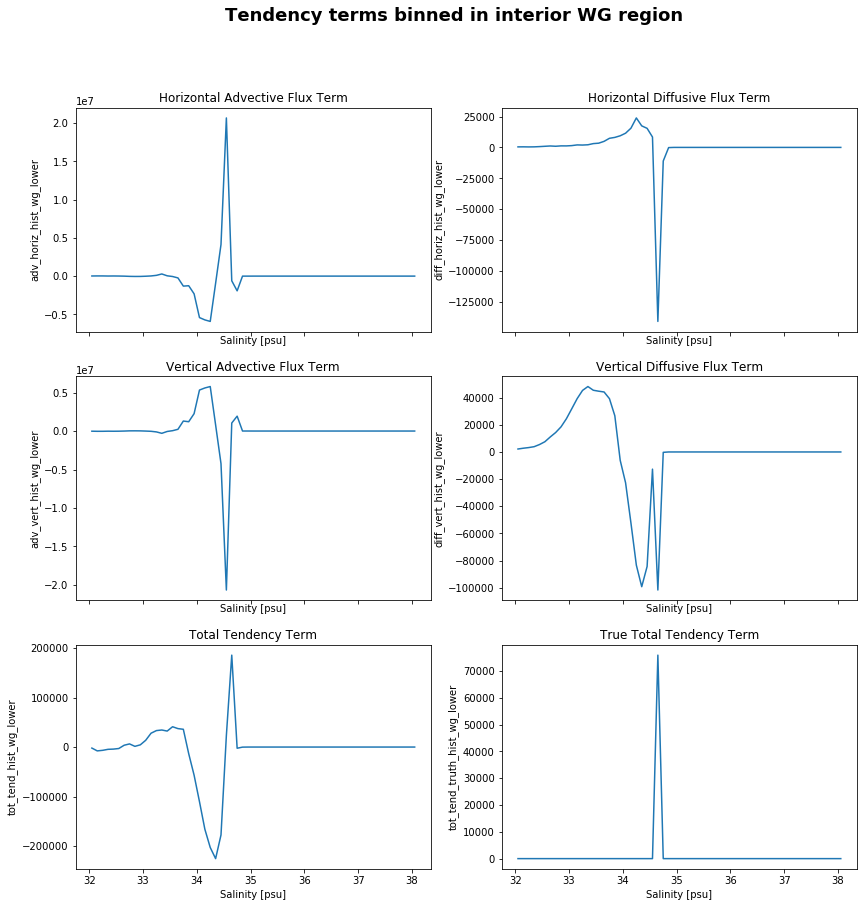

<Figure size 432x288 with 0 Axes>

In [55]:
fig, axes = plt.subplots(nrows=3, ncols=2, sharex=True, figsize=(14,14))

ds_hist_wg_lower_mean.adv_horiz_hist_wg_lower.transpose().plot(ax=axes[0,0])
ds_hist_wg_lower_mean.diff_horiz_hist_wg_lower.transpose().plot(ax=axes[0,1])
ds_hist_wg_lower_mean.adv_vert_hist_wg_lower.transpose().plot(ax=axes[1,0])
ds_hist_wg_lower_mean.diff_vert_hist_wg_lower.transpose().plot(ax=axes[1,1])
ds_hist_wg_lower_mean.tot_tend_hist_wg_lower.transpose().plot(ax=axes[2,0])
ds_hist_wg_lower_mean.tot_tend_truth_hist_wg_lower.transpose().plot(ax=axes[2,1])

fig.suptitle('Tendency terms binned in interior WG region', fontsize=18, fontweight='bold')

axes[0,0].title.set_text('Horizontal Advective Flux Term')
axes[0,1].title.set_text('Horizontal Diffusive Flux Term')
axes[1,0].title.set_text('Vertical Advective Flux Term')
axes[1,1].title.set_text('Vertical Diffusive Flux Term')
axes[2,0].title.set_text('Total Tendency Term')
axes[2,1].title.set_text('True Total Tendency Term')
#axes[3,0].title.set_text('Shortwave Term')
#axes[3,1].title.set_text('Total Tendency Term')

plt.show() #this seems to work to make suptitle displayed neatly above
plt.tight_layout();

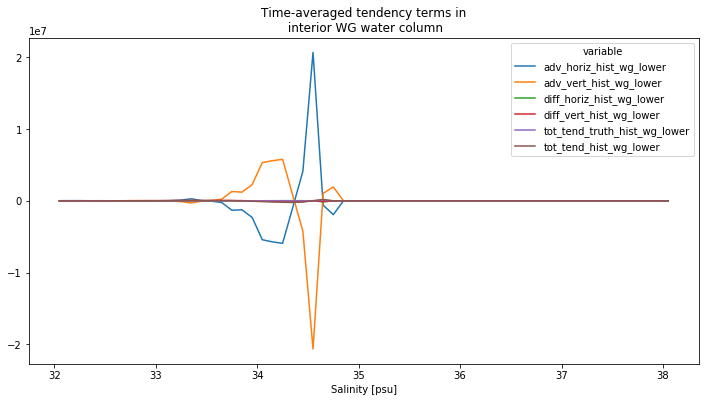

In [57]:
plt.figure(figsize=(12,6))
ds_hist_wg_lower_mean.to_array().plot.line(x='SALT_bin')
plt.title('Time-averaged tendency terms in\n interior WG water column');

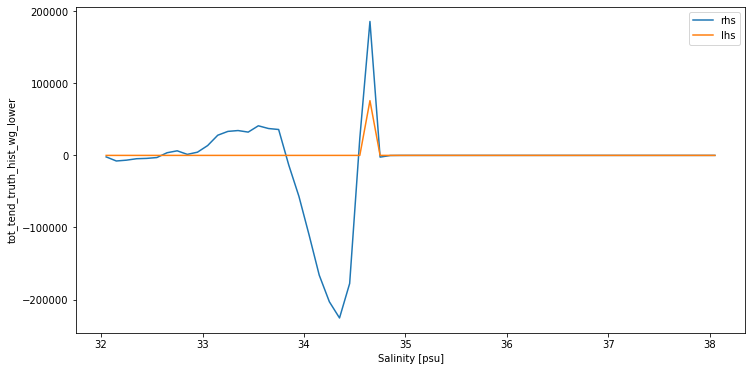

In [58]:
plt.figure(figsize=(12,6))
ds_hist_wg_lower_mean.tot_tend_hist_wg_lower.plot(label='rhs')
ds_hist_wg_lower_mean.tot_tend_truth_hist_wg_lower.plot(label='lhs')
plt.legend();